<a href="https://colab.research.google.com/github/kogorkus/colab/blob/main/PV061_Assigments_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Errors in training data

Korpus News-Commentary v16, ktery jsem nasledne pouzil pro trenovani modelu, je docela kvalitni, ale i v nem se daji najit drobnosti, ktere muzeme brat jako chyby v datech. Nespravny alignment, chybny nebo prilis kontextove zavisly preklad.

 
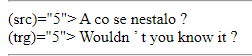

# NMT Model

## Priprava dat

Pro pripravu dat jsem vyuzil Github repository MT-Preparation

In [ ]:
!git clone https://github.com/ymoslem/MT-Preparation.git

Cloning into 'MT-Preparation'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 207 (delta 104), reused 184 (delta 94), pack-reused 0
Receiving objects: 100% (207/207), 50.84 KiB | 309.00 KiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
# slozka pro ulozeni dat a modelu

!mkdir nmt
%cd nmt

/content/nmt


In [ ]:
# instalace requirements

!pip3 install -r MT-Preparation/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.2 MB/s 


Jako zdroj dat jsem zvolil korpus novinovych clanku News-Commentary v16 zverejneny na: https://opus.nlpl.eu/News-Commentary-v16.php


In [ ]:
# stahovani korpusu

!wget https://object.pouta.csc.fi/OPUS-News-Commentary/v16/moses/cs-en.txt.zip
!unzip cs-en.txt.zip

--2022-12-15 03:46:09--  https://object.pouta.csc.fi/OPUS-News-Commentary/v16/moses/cs-en.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23374077 (22M) [application/zip]
Saving to: ‘cs-en.txt.zip’

cs-en.txt.zip       100%[===================>]  22.29M  6.68MB/s    in 3.3s    

2022-12-15 03:46:14 (6.68 MB/s) - ‘cs-en.txt.zip’ saved [23374077/23374077]

Archive:  cs-en.txt.zip
  inflating: README                  
  inflating: LICENSE                 
  inflating: News-Commentary.cs-en.cs  
  inflating: News-Commentary.cs-en.en  
  inflating: News-Commentary.cs-en.xml  


In [ ]:
# filtrace dat

!python3 MT-Preparation/filtering/filter.py News-Commentary.cs-en.cs News-Commentary.cs-en.en cs en

Dataframe shape (rows, columns): (218509, 2)
--- Rows with Empty Cells Deleted	--> Rows: 212700
--- Duplicates Deleted			--> Rows: 212208
--- Source-Copied Rows Deleted		--> Rows: 212145
--- Too Long Source/Target Deleted	--> Rows: 208649
--- HTML Removed			--> Rows: 208649
--- Rows will remain in true-cased	--> Rows: 208649
--- Rows with Empty Cells Deleted	--> Rows: 208648
--- Rows Shuffled			--> Rows: 208648
--- Source Saved: News-Commentary.cs-en.cs-filtered.cs
--- Target Saved: News-Commentary.cs-en.en-filtered.en


In [ ]:
# trenovani modelu SentencePiece pro tokenizaci textu

!python MT-Preparation/subwording/1-train_unigram.py News-Commentary.cs-en.cs-filtered.cs News-Commentary.cs-en.en-filtered.en

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=News-Commentary.cs-en.cs-filtered.cs --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --split_digits=true
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: News-Commentary.cs-en.cs-filtered.cs
  input_format: 
  model_prefix: source
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos

In [ ]:
# subwording dat

!python3 MT-Preparation/subwording/2-subword.py source.model target.model News-Commentary.cs-en.cs-filtered.cs News-Commentary.cs-en.en-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: News-Commentary.cs-en.cs-filtered.cs
Target Dataset: News-Commentary.cs-en.en-filtered.en
Done subwording the source file! Output: News-Commentary.cs-en.cs-filtered.cs.subword
Done subwording the target file! Output: News-Commentary.cs-en.en-filtered.en.subword


In [ ]:
# rozdeleni dat na trenovaci, testovaci a dev sadu

!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 News-Commentary.cs-en.cs-filtered.cs.subword News-Commentary.cs-en.en-filtered.en.subword

Dataframe shape: (208648, 2)
--- Empty Cells Deleted --> Rows: 208648
--- Wrote Files
Done!
Output files
News-Commentary.cs-en.cs-filtered.cs.subword.train
News-Commentary.cs-en.en-filtered.en.subword.train
News-Commentary.cs-en.cs-filtered.cs.subword.dev
News-Commentary.cs-en.en-filtered.en.subword.dev
News-Commentary.cs-en.cs-filtered.cs.subword.test
News-Commentary.cs-en.en-filtered.en.subword.test


In [ ]:
# vypis datovych sad a jejich velikosti

!wc -l *.subword.*

    2000 News-Commentary.cs-en.cs-filtered.cs.subword.dev
    2000 News-Commentary.cs-en.cs-filtered.cs.subword.test
  204648 News-Commentary.cs-en.cs-filtered.cs.subword.train
    2000 News-Commentary.cs-en.en-filtered.en.subword.dev
    2000 News-Commentary.cs-en.en-filtered.en.subword.test
  204648 News-Commentary.cs-en.en-filtered.en.subword.train
  417296 total


In [ ]:
# model a data nejlepe ulozit na Google Discu

from google.colab import drive
drive.mount('/content/drive')

!cp -R /content/nmt/ /content/drive/MyDrive/nmt

## Trenovani modelu

Zvolil jsem NMT system OpenNMT


In [ ]:
!pip3 install OpenNMT-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 4.2 MB/s 
     |████████████████████████████████| 16.7 MB 431 kB/s 
     |████████████████████████████████| 30.6 MB 50.1 MB/s 
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 118 kB 55.1 MB/s 


In [ ]:
# vytvoreni config souboru pro trenovani modelu
# vetsinu techto konfiguraci jsem nechal stejne jako v ukazce trenovani modelu na mensim korpusu
# zmensil jsem learning_rate z 2 do 1 kvuli tomu ze model natrenovany s learning_rate 2 na danem korpusu
# generuje vetsinou nesmyslne preklady

config = '''# config.yaml


## Where the samples will be written
save_data: run

# Training files
data:
    corpus_1:
        path_src: News-Commentary.cs-en.cs-filtered.cs.subword.train
        path_tgt: News-Commentary.cs-en.en-filtered.en.subword.train
        transforms: [filtertoolong]
    valid:
        path_src: News-Commentary.cs-en.cs-filtered.cs.subword.dev
        path_tgt: News-Commentary.cs-en.en-filtered.en.subword.dev
        transforms: [filtertoolong]

# Vocabulary files, generated by onmt_build_vocab
src_vocab: run/source.vocab
tgt_vocab: run/target.vocab

# Vocabulary size - should be the same as in sentence piece
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filter out source/target longer than n if [filtertoolong] enabled
src_seq_length: 150
src_seq_length: 150

# Tokenization options
src_subword_model: source.model
tgt_subword_model: target.model

# Where to save the log file and the output models/checkpoints
log_file: train.log
save_model: models/nmt_model.fren

# Stop training if it does not imporve after n validations
early_stopping: 4

# Default: 5000 - Save a model checkpoint for each n
save_checkpoint_steps: 1000

# To save space, limit checkpoints to last n
# keep_checkpoint: 3

seed: 3435

# Default: 100000 - Train the model to max n steps 
# Increase to 200000 or more for large datasets
# For fine-tuning, add up the required steps to the original steps
train_steps: 3000

# Default: 10000 - Run validation after n steps
valid_steps: 1000

# Default: 4000 - for large datasets, try up to 8000
warmup_steps: 1000
report_every: 100

# Number of GPUs, and IDs of GPUs
world_size: 1
gpu_ranks: [0]

# Batching
bucket_size: 262144
num_workers: 0  # Default: 2, set to 0 when RAM out of memory
batch_type: "tokens"
batch_size: 4096   # Tokens per batch, change when CUDA out of memory
valid_batch_size: 2048
max_generator_batches: 2
accum_count: [4]
accum_steps: [0]

# Optimization
model_dtype: "fp16"
optim: "adam"
learning_rate: 1
# warmup_steps: 8000
decay_method: "noam"
adam_beta2: 0.998
max_grad_norm: 0
label_smoothing: 0.1
param_init: 0
param_init_glorot: true
normalization: "tokens"

# Model
encoder_type: transformer
decoder_type: transformer
position_encoding: true
enc_layers: 6
dec_layers: 6
heads: 8
hidden_size: 512
word_vec_size: 512
transformer_ff: 2048
dropout_steps: [0]
dropout: [0.1]
attention_dropout: [0.1]
'''

with open("config.yaml", "w+") as config_yaml:
    config_yaml.write(config)

In [ ]:
# vytvoreni vocabulary

!onmt_build_vocab -config config.yaml -n_sample -1

Corpus corpus_1's weight should be given. We default it to 1 for you.
[2022-12-15 03:18:32,129 INFO] Counter vocab from -1 samples.
[2022-12-15 03:18:32,129 INFO] n_sample=-1: Build vocab on full datasets.
[2022-12-15 03:18:38,244 INFO] * Transform statistics for corpus_1(100.00%):
			* FilterTooLongStats(filtered=3)

[2022-12-15 03:18:38,331 INFO] Counters src:50113
[2022-12-15 03:18:38,331 INFO] Counters tgt:49467


In [ ]:
# vytvoreni slozky pro natrenovane modely

!rm -rf drive/MyDrive/nmt/models/

In [ ]:
# pouziti GPU pro trenovani modelu

!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-e4eb837f-d733-5862-6f7d-36680ac77e8f)


In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

gpu_memory = torch.cuda.mem_get_info(0)
print("Free GPU memory:", gpu_memory[0]/1024**2, "out of:", gpu_memory[1]/1024**2)

True
Tesla T4
Free GPU memory: 15007.75 out of: 15109.75


In [ ]:
# trenovani NMT modelu

!onmt_train -config config.yaml

## Preklad

In [ ]:
# preklad testove sady pomoci modelu z kazdeho z 3 checkpointu tenovani

!onmt_translate -model models/new_model.fren_step_1000.pt -src News-Commentary.cs-en.cs-filtered.cs.subword.test -output News-Commentary.en.translated_1000 -gpu 0 -min_length 1
!onmt_translate -model models/new_model.fren_step_2000.pt -src News-Commentary.cs-en.cs-filtered.cs.subword.test -output News-Commentary.en.translated_2000 -gpu 0 -min_length 1
!onmt_translate -model models/new_model.fren_step_3000.pt -src News-Commentary.cs-en.cs-filtered.cs.subword.test -output News-Commentary.en.translated_3000 -gpu 0 -min_length 1


*   PRED SCORE: -1.1106, PRED PPL: 3.04 NB SENTENCES: 2000

*   PRED SCORE: -0.5517, PRED PPL: 1.74 NB SENTENCES: 2000

*   PRED SCORE: -0.4201, PRED PPL: 1.52 NB SENTENCES: 2000

In [ ]:
# desubwording prekladu

!python3 MT-Preparation/subwording/3-desubword.py target.model News-Commentary.en.translated_1000
!python3 MT-Preparation/subwording/3-desubword.py target.model News-Commentary.en.translated_2000
!python3 MT-Preparation/subwording/3-desubword.py target.model News-Commentary.en.translated_3000

Done desubwording! Output: News-Commentary.en.translated_1000.desubword
Done desubwording! Output: News-Commentary.en.translated_2000.desubword
Done desubwording! Output: News-Commentary.en.translated_3000.desubword


In [ ]:
# desubwording testovaci sady

!python3 MT-Preparation/subwording/3-desubword.py target.model News-Commentary.cs-en.en-filtered.en.subword.test

Done desubwording! Output: News-Commentary.cs-en.en-filtered.en.subword.test.desubword


In [ ]:
# prvnich 10 radku

!head -n 10 News-Commentary.cs-en.en-filtered.en.subword.test.desubword

Increasing dependence on energy imports was often cited as evidence.
We must reach across old dividing lines – both within economies and between them – and work together to build a stronger, more resilient global economy.
During the war, the emperor was omnipotent in theory, but relatively powerless in fact.
And the share of active workers with a university education remains at levels barely comparable with other advanced economies.
What is clear is that the experience of countries that have implemented the treaty has not been particularly positive, unless those countries have a high tolerance for bureaucratic regulatory regimes that stifle innovation and development in the name of lofty aspirations.
Questions for Robert Zoellick
Well, the data contradicts him: using policies that he directly or indirectly advocates -such as using deficits first and inflation later to solve fiscal problems - is especially bad for the poor.
In other words, Argentina has failed to become a technology-bas

In [ ]:
!head -n 10 News-Commentary.en.translated_1000.desubword

As a result, it is often growing to import imports.
We need to be seen in the old world – both economies and emerging economies – to support the global economy – together with more stable and stable global economy.
For example, in the war, it was not the case of the 1980’s, for example, for example.
Second, the share of workers with education remains low, which is difficult to find in other advanced economies.
But what is clear, however, is clear that countries that have been too high, if not because of the country’s management of innovation and development in the name of innovation.
In the case of the 1980’s, Igor Ivanov.
Whether politics or other policies, such as the use of fiscal deficits - have been put in order to address the problem - is especially true for the poor.
In other words, Argentina has failed to compete with the economy.
It should be seen as a surprise: I should not think of the past in the past, and should consider that the right thing.
Only by those who are Europe’s

In [ ]:
!head -n 10 News-Commentary.en.translated_2000.desubword

And, as evidence, it is often noted, increasing dependence on energy imports.
We need to reach across the old divide – both within economies and between them – and to work together to build a stronger and more resilient global economy.
The imperial Kaiser, for example, was practically powerless, but essentially powerless.
And the share of active workers with a university education remains at levels that are hardly comparable to other advanced economies.
But what is clear is that the experience of countries that adopted the treaty was not too positive if these countries had a high tolerance for bureaucratic regulatory regimes that suppress innovation and development in the name of lofty aspirations.
The Questions of Robert Zoellick
Well, the facts are: policies that directly or indirectly espouse - for example, the use of deficits first and inflation to solve fiscal problems - are particularly damaging to the poor.
In other words, Argentina failed to develop an economy-supported technol

In [ ]:
!head -n 10 News-Commentary.en.translated_3000.desubword

And, as evidence, increasing dependence on energy imports has often been shown.
We need to transcend the old divisions – both within economies and between them – and work together to build a stronger, more resilient global economy.
The Kaiser, for example, was omnipotent in the war, but virtually powerless.
And the share of active workers with university education remains at levels that are hardly comparable to other advanced economies.
But what is clear is that the experience of countries that have already adopted the Treaty was not too positive if these countries had little tolerance for bureaucratic regulatory regimes that inhibit innovation and development in the name of lofty aspirations.
Questions for Robert Zoellick
Well, the facts contradict him: policies that directly or indirectly defend - for example, the use of deficits first and then inflation to solve fiscal problems - is especially bad for the poor.
In other words, Argentina failed to develop an economy supported by tech

## Evaluace

Evaluace pomoci metriky BLEU

In [ ]:
!wget https://raw.githubusercontent.com/ymoslem/MT-Evaluation/main/BLEU/compute-bleu.py

--2022-12-15 03:58:00--  https://raw.githubusercontent.com/ymoslem/MT-Evaluation/main/BLEU/compute-bleu.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957 [text/plain]
Saving to: ‘compute-bleu.py’

compute-bleu.py     100%[===================>]     957  --.-KB/s    in 0s      

2022-12-15 03:58:00 (41.2 MB/s) - ‘compute-bleu.py’ saved [957/957]



In [ ]:
!pip3 install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# evlauace prekladu kazdeho z 3 modelu

!python3 compute-bleu.py News-Commentary.cs-en.en-filtered.en.subword.test.desubword News-Commentary.en.translated_1000.desubword
!python3 compute-bleu.py News-Commentary.cs-en.en-filtered.en.subword.test.desubword News-Commentary.en.translated_2000.desubword
!python3 compute-bleu.py News-Commentary.cs-en.en-filtered.en.subword.test.desubword News-Commentary.en.translated_3000.desubword

Reference 1st sentence: Increasing dependence on energy imports was often cited as evidence.
MTed 1st sentence: As a result, it is often growing to import imports.
BLEU:  10.414543313472791
Reference 1st sentence: Increasing dependence on energy imports was often cited as evidence.
MTed 1st sentence: And, as evidence, it is often noted, increasing dependence on energy imports.
BLEU:  31.753865363168956
Reference 1st sentence: Increasing dependence on energy imports was often cited as evidence.
MTed 1st sentence: And, as evidence, increasing dependence on energy imports has often been shown.
BLEU:  42.73329733711973



*   BLEU 10.414543313472791
*   BLEU 31.753865363168956
*   BLEU 42.73329733711973



# Evaluace domeny

In [ ]:
# korpus PDF souboru European Medicines Agency (EMEA)

!wget https://object.pouta.csc.fi/OPUS-ELRC_2682/v1/moses/cs-en.txt.zip

In [ ]:
!unzip cs-en.txt.zip.2

Archive:  cs-en.txt.zip.2
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: README                  
  inflating: LICENSE                 
  inflating: ELRC_2682.cs-en.cs      
  inflating: ELRC_2682.cs-en.en      
  inflating: ELRC_2682.cs-en.xml     


In [ ]:
!python3 MT-Preparation/filtering/filter.py ELRC_2682.cs-en.cs ELRC_2682.cs-en.en cs en

Dataframe shape (rows, columns): (779082, 2)
--- Rows with Empty Cells Deleted	--> Rows: 779065
--- Duplicates Deleted			--> Rows: 778740
--- Source-Copied Rows Deleted		--> Rows: 778740
--- Too Long Source/Target Deleted	--> Rows: 761361
--- HTML Removed			--> Rows: 761361
--- Rows will remain in true-cased	--> Rows: 761361
--- Rows with Empty Cells Deleted	--> Rows: 761084
--- Rows Shuffled			--> Rows: 761084
--- Source Saved: ELRC_2682.cs-en.cs-filtered.cs
--- Target Saved: ELRC_2682.cs-en.en-filtered.en


In [ ]:
!python3 MT-Preparation/subwording/2-subword.py source.model target.model ELRC_2682.cs-en.cs-filtered.cs ELRC_2682.cs-en.en-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: ELRC_2682.cs-en.cs-filtered.cs
Target Dataset: ELRC_2682.cs-en.en-filtered.en
Done subwording the source file! Output: ELRC_2682.cs-en.cs-filtered.cs.subword
Done subwording the target file! Output: ELRC_2682.cs-en.en-filtered.en.subword


In [ ]:
!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 ELRC_2682.cs-en.cs-filtered.cs.subword ELRC_2682.cs-en.en-filtered.en.subword

Dataframe shape: (761084, 2)
--- Empty Cells Deleted --> Rows: 761084
--- Wrote Files
Done!
Output files
ELRC_2682.cs-en.cs-filtered.cs.subword.train
ELRC_2682.cs-en.en-filtered.en.subword.train
ELRC_2682.cs-en.cs-filtered.cs.subword.dev
ELRC_2682.cs-en.en-filtered.en.subword.dev
ELRC_2682.cs-en.cs-filtered.cs.subword.test
ELRC_2682.cs-en.en-filtered.en.subword.test


In [ ]:
!onmt_translate -model nmt/nmt/models/new_model.fren_step_3000.pt -src ELRC_2682.cs-en.en-filtered.en.subword.test -output News-ELRC_2682.en.translated_3000 -gpu 0 -min_length 1

[2022-12-15 04:32:54,626 INFO] PRED SCORE: -1.0159, PRED PPL: 2.76 NB SENTENCES: 2000


In [ ]:
!python3 MT-Preparation/subwording/3-desubword.py target.model News-ELRC_2682.en.translated_3000

Done desubwording! Output: News-ELRC_2682.en.translated_3000.desubword


In [ ]:
!python3 MT-Preparation/subwording/3-desubword.py target.model ELRC_2682.cs-en.en-filtered.en.subword.test

Done desubwording! Output: ELRC_2682.cs-en.en-filtered.en.subword.test.desubword


In [ ]:
!head -n 10 ELRC_2682.cs-en.en-filtered.en.subword.test.desubword

For information on vaccinations see section 4.4.
[EMEA/103390/2009] The Management Board noted the ongoing discussion between the CHMP and the CAT regarding the CAT rules of procedure and the procedural advice on evaluation of ATMPs.
Primary endpointa
Particular attention should be paid to sudden stabbing migraine-like headaches as a possible warning signal (see section 4.8).
No modification of vinflunine and DVFL pharmacokinetics was observed in 25 patients presenting varying degrees of hepatic impairment, compared to patients with normal hepatic function.
Rivastigmine Teva 6 mg hard capsules contains 6 mg rivastigmine as rivastigmine hydrogen tartrate
What is Suprelorin used for?
Example a 1g/kg IVIG dose given every 3 weeks would convert into a 0.33g/kg weekly Hizentra dose.
Conversely, increases in serum potassium have been observed with aliskiren in post-marketing experience and these may be exacerbated by concomitant use of other agents acting on the RAAS or by non-steroidal anti

In [ ]:
!head -n 10 News-ELRC_2682.en.translated_3000.desubword

For example, he 4.4.
[/10390/2009, The Monterrey Consensus, the Management of the 1930-2009, and the 1930’s and 1930-2009 AD, Mr. W.W.W.W.C.
The Tinkerer’s Apprentice
RANKING WORLD INVESTMENTS
Nomadic and G-25, 25,000 cheering, is a mixed blessing.
RANKING WORLD INVESTMENTS
Is soup B?
The B/11/11/word for 33,000Gt, and 33/word/word/word for smoke.
TOLEDO, SPAIN, Shaul Muammar el-Sheikh and post-kala-azar dermal leishmaniasis.
• A disqualification of the Joint Offensive.


In [ ]:
!python3 compute-bleu.py ELRC_2682.cs-en.en-filtered.en.subword.test.desubword News-ELRC_2682.en.translated_3000.desubword

Reference 1st sentence: For information on vaccinations see section 4.4.
MTed 1st sentence: For example, he 4.4.
BLEU:  1.383909335336981


BLEU:  1.383909335336981

Vysledky evaluace prekladu textu obsahujicich odbornou lekarskou terminologii pomoci metriky BLEU jsou podle ocekavani nizke. Pricemz pro preklad byl pouzit nejlepsi ze vsech modelu 3000, co mel na puvodni testvaci sade vysledek BLEU 42.7.

# Evaluace domeny 2

In [ ]:
# kolekce prekladu Koranu, velke mnozstvi nabozenske terminologie

!wget https://object.pouta.csc.fi/OPUS-Tanzil/v1/moses/cs-en.txt.zip

--2022-12-15 06:10:37--  https://object.pouta.csc.fi/OPUS-Tanzil/v1/moses/cs-en.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18106526 (17M) [application/zip]
Saving to: ‘cs-en.txt.zip’

cs-en.txt.zip       100%[===================>]  17.27M  4.71MB/s    in 3.7s    

2022-12-15 06:10:42 (4.71 MB/s) - ‘cs-en.txt.zip’ saved [18106526/18106526]



In [ ]:
!unzip cs-en.txt.zip

Archive:  cs-en.txt.zip
  inflating: Tanzil.cs-en.cs         
  inflating: Tanzil.cs-en.en         
  inflating: Tanzil.cs-en.ids        
  inflating: README                  


In [ ]:
!python3 MT-Preparation/filtering/filter.py Tanzil.cs-en.cs Tanzil.cs-en.en cs en

Dataframe shape (rows, columns): (233399, 2)
--- Rows with Empty Cells Deleted	--> Rows: 233399
--- Duplicates Deleted			--> Rows: 228644
--- Source-Copied Rows Deleted		--> Rows: 228643
--- Too Long Source/Target Deleted	--> Rows: 219324
--- HTML Removed			--> Rows: 219324
--- Rows will remain in true-cased	--> Rows: 219324
--- Rows with Empty Cells Deleted	--> Rows: 219324
--- Rows Shuffled			--> Rows: 219324
--- Source Saved: Tanzil.cs-en.cs-filtered.cs
--- Target Saved: Tanzil.cs-en.en-filtered.en


In [ ]:
!python MT-Preparation/subwording/1-train_unigram.py Tanzil.cs-en.cs-filtered.cs Tanzil.cs-en.en-filtered.en

In [ ]:
!python3 MT-Preparation/subwording/2-subword.py source.model target.model Tanzil.cs-en.cs-filtered.cs Tanzil.cs-en.en-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: Tanzil.cs-en.cs-filtered.cs
Target Dataset: Tanzil.cs-en.en-filtered.en
Done subwording the source file! Output: Tanzil.cs-en.cs-filtered.cs.subword
Done subwording the target file! Output: Tanzil.cs-en.en-filtered.en.subword


In [ ]:
!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 Tanzil.cs-en.cs-filtered.cs.subword Tanzil.cs-en.en-filtered.en.subword

Dataframe shape: (219324, 2)
--- Empty Cells Deleted --> Rows: 219324
--- Wrote Files
Done!
Output files
Tanzil.cs-en.cs-filtered.cs.subword.train
Tanzil.cs-en.en-filtered.en.subword.train
Tanzil.cs-en.cs-filtered.cs.subword.dev
Tanzil.cs-en.en-filtered.en.subword.dev
Tanzil.cs-en.cs-filtered.cs.subword.test
Tanzil.cs-en.en-filtered.en.subword.test


In [ ]:
!onmt_translate -model drive/MyDrive/nmt/models/new_model.fren_step_3000.pt -src Tanzil.cs-en.en-filtered.en.subword.test -output Tanzil.en.translated_3000 -gpu 0 -min_length 1

Traceback (most recent call last):
  File "/usr/local/bin/onmt_translate", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/dist-packages/onmt/bin/translate.py", line 60, in main
    translate(opt)
  File "/usr/local/lib/python3.8/dist-packages/onmt/bin/translate.py", line 23, in translate
    translator = build_translator(opt, logger=logger,
  File "/usr/local/lib/python3.8/dist-packages/onmt/translate/translator.py", line 31, in build_translator
    vocabs, model, model_opt = load_test_model(opt)
  File "/usr/local/lib/python3.8/dist-packages/onmt/model_builder.py", line 105, in load_test_model
    model = build_base_model(model_opt, vocabs, use_gpu(opt), checkpoint,
  File "/usr/local/lib/python3.8/dist-packages/onmt/model_builder.py", line 319, in build_base_model
    model.to(device)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 987, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.8/dist-packages/torc

In [ ]:
# v tomto okamziku mi dosly Compute unity Colabu dal uz jsem musel provadet vypocty jen pomoci CPU misto GPU

In [ ]:
!onmt_translate -model drive/MyDrive/nmt/models/new_model.fren_step_3000.pt -src Tanzil.cs-en.en-filtered.en.subword.test -output Tanzil.en.translated_3000 -min_length 1

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/onmt/translate/translator.py", line 723, in translate_batch
    return self._translate_batch_with_strategy(
  File "/usr/local/lib/python3.8/dist-packages/onmt/translate/translator.py", line 803, in _translate_batch_with_strategy
    log_probs, attn = self._decode_and_generate(
  File "/usr/local/lib/python3.8/dist-packages/onmt/translate/translator.py", line 539, in _decode_and_generate
    dec_out, dec_attn = self.model.decoder(
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/onmt/decoders/transformer.py", line 461, in forward
    dec_out, attn, attn_align = layer(
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/onmt/decoder

# Optimizace trenovani

In [ ]:
# pouzil jsem BPE misto train_unigram

!python MT-Preparation/subwording/1-train_bpe.py News-Commentary.cs-en.cs-filtered.cs News-Commentary.cs-en.en-filtered.en

Выходные данные были обрезаны до нескольких последних строк (5000).
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=55 size=17700 all=199183 active=9978 piece=▁zkorumpované
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=55 min_freq=28
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17720 all=199416 active=10193 piece=▁Mul
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17740 all=199572 active=10349 piece=▁doty
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17760 all=199653 active=10430 piece=▁listu
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17780 all=199730 active=10507 piece=▁mladým
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17800 all=199783 active=10560 piece=▁evoluce
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=54 min_freq=28
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17820 all=199793 active=10000 piece=▁výrobců
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=54 size=17840

In [ ]:
!python3 MT-Preparation/subwording/2-subword.py source.model target.model News-Commentary.cs-en.cs-filtered.cs News-Commentary.cs-en.en-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: News-Commentary.cs-en.cs-filtered.cs
Target Dataset: News-Commentary.cs-en.en-filtered.en
Done subwording the source file! Output: News-Commentary.cs-en.cs-filtered.cs.subword
Done subwording the target file! Output: News-Commentary.cs-en.en-filtered.en.subword


In [ ]:
!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 News-Commentary.cs-en.cs-filtered.cs.subword News-Commentary.cs-en.en-filtered.en.subword

Dataframe shape: (208648, 2)
--- Empty Cells Deleted --> Rows: 208648
--- Wrote Files
Done!
Output files
News-Commentary.cs-en.cs-filtered.cs.subword.train
News-Commentary.cs-en.en-filtered.en.subword.train
News-Commentary.cs-en.cs-filtered.cs.subword.dev
News-Commentary.cs-en.en-filtered.en.subword.dev
News-Commentary.cs-en.cs-filtered.cs.subword.test
News-Commentary.cs-en.en-filtered.en.subword.test


In [ ]:

config = '''# config.yaml


## Where the samples will be written
save_data: run

# Training files
data:
    corpus_1:
        path_src: News-Commentary.cs-en.cs-filtered.cs.subword.train
        path_tgt: News-Commentary.cs-en.en-filtered.en.subword.train
        transforms: [filtertoolong]
    valid:
        path_src: News-Commentary.cs-en.cs-filtered.cs.subword.dev
        path_tgt: News-Commentary.cs-en.en-filtered.en.subword.dev
        transforms: [filtertoolong]

# Vocabulary files, generated by onmt_build_vocab
src_vocab: run/source.vocab
tgt_vocab: run/target.vocab

# Vocabulary size - should be the same as in sentence piece
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filter out source/target longer than n if [filtertoolong] enabled
src_seq_length: 150
src_seq_length: 150

# Tokenization options
src_subword_model: source.model
tgt_subword_model: target.model

# Where to save the log file and the output models/checkpoints
log_file: train.log
save_model: models/bpe_model.fren

# Stop training if it does not imporve after n validations
early_stopping: 4

# Default: 5000 - Save a model checkpoint for each n
save_checkpoint_steps: 1000

# To save space, limit checkpoints to last n
# keep_checkpoint: 3

seed: 3435

# Default: 100000 - Train the model to max n steps 
# Increase to 200000 or more for large datasets
# For fine-tuning, add up the required steps to the original steps
train_steps: 3000

# Default: 10000 - Run validation after n steps
valid_steps: 1000

# Default: 4000 - for large datasets, try up to 8000
warmup_steps: 1000
report_every: 100

# Number of GPUs, and IDs of GPUs
world_size: 1
gpu_ranks: [0]

# Batching
bucket_size: 262144
num_workers: 0  # Default: 2, set to 0 when RAM out of memory
batch_type: "tokens"
batch_size: 4096   # Tokens per batch, change when CUDA out of memory
valid_batch_size: 2048
max_generator_batches: 2
accum_count: [4]
accum_steps: [0]

# Optimization
model_dtype: "fp16"
optim: "adam"
learning_rate: 1
# warmup_steps: 8000
decay_method: "noam"
adam_beta2: 0.998
max_grad_norm: 0
label_smoothing: 0.1
param_init: 0
param_init_glorot: true
normalization: "tokens"

# Model
encoder_type: transformer
decoder_type: transformer
position_encoding: true
enc_layers: 6
dec_layers: 6
heads: 8
hidden_size: 512
word_vec_size: 512
transformer_ff: 2048
dropout_steps: [0]
dropout: [0.1]
attention_dropout: [0.1]
'''

with open("config.yaml", "w+") as config_yaml:
    config_yaml.write(config)

In [ ]:
!onmt_build_vocab -config config.yaml -n_sample -1

Corpus corpus_1's weight should be given. We default it to 1 for you.
[2022-12-15 04:52:53,556 INFO] Counter vocab from -1 samples.
[2022-12-15 04:52:53,557 INFO] n_sample=-1: Build vocab on full datasets.
[2022-12-15 04:52:59,754 INFO] * Transform statistics for corpus_1(100.00%):
			* FilterTooLongStats(filtered=2)

[2022-12-15 04:52:59,897 INFO] Counters src:49558
[2022-12-15 04:52:59,897 INFO] Counters tgt:46549


In [ ]:
!onmt_train -config config.yaml

[2022-12-15 04:53:33,447 WARNING] Corpus corpus_1's weight should be given. We default it to 1 for you.
[2022-12-15 04:53:33,447 INFO] Parsed 2 corpora from -data.
[2022-12-15 04:53:33,447 INFO] Get special vocabs from Transforms: {'src': [], 'tgt': []}.
[2022-12-15 04:53:33,712 INFO] Building model...
[2022-12-15 04:53:37,177 INFO] NMTModel(
  (encoder): TransformerEncoder(
    (embeddings): Embeddings(
      (make_embedding): Sequential(
        (emb_luts): Elementwise(
          (0): Embedding(49568, 512, padding_idx=1)
        )
        (pe): PositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (transformer): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linear_keys): Linear(in_features=512, out_features=512, bias=False)
          (linear_values): Linear(in_features=512, out_features=512, bias=False)
          (linear_query): Linear(in_features=512, out_features=512, bias=False)
  

In [ ]:
# preklad testove sady pomoci modelu z kazdeho z 3 checkpointu tenovani

!onmt_translate -model models/bpe_model.fren_step_1000.pt -src News-Commentary.cs-en.cs-filtered.cs.subword.test -output News-Commentary.en.translated_1000 -gpu 0 -min_length 1
!onmt_translate -model models/bpe_model.fren_step_2000.pt -src News-Commentary.cs-en.cs-filtered.cs.subword.test -output News-Commentary.en.translated_2000 -gpu 0 -min_length 1
!onmt_translate -model models/bpe_model.fren_step_3000.pt -src News-Commentary.cs-en.cs-filtered.cs.subword.test -output News-Commentary.en.translated_3000 -gpu 0 -min_length 1


**UNIGRAM**

*   Train perplexity: 16.4436
*   Train accuracy: 48.6455
*   Sentences processed: 1.57443e+06
*   Average bsz: 3413/3571/131
*   Validation perplexity: 7.21949
*   Validation accuracy: 63.6551
*   Model is improving ppl: 8.86147 --> 7.21949.
*   Model is improving acc: 60.2069 --> 63.6551.









**BPE**

*   Train perplexity: 17.2087
*   Train accuracy: 48.0407
*   Sentences processed: 1.60458e+06
*   Average bsz: 3350/3596/134
*   Validation perplexity: 8.13923   
*   Validation accuracy: 62.0012
*   Model is improving ppl: 10.0928 --> 8.13923
*   Model is improving acc: 60.2069 --> 63.6551




Bohuzel se mi nepodarilo otestovat dany model a provest evaluaci prekladu kvuli tomu, ze mi dosly Compute unity Colabu, on odmitl spoustet GPU pro vypocty a restartoval cele prostredi, coz smazalo posledni natrenovane modely. 

Kazdopadne na zaklade trenovacich logu muzeme sledovat vlastnosti modelu. Model natrenovany na datech, na kterych byl proveden subwording pomoci BPE ma vyssi miru perplexity a mensi presnost, nez model natrenovany na datech, na kterych byl proveden subwording pomoci Unigramu.

# Zdroje

https://github.com/OpenNMT/OpenNMT-py

https://github.com/ymoslem/OpenNMT-Tutorial

https://opennmt.net/OpenNMT-py/index.html

https://opus.nlpl.eu/

https://github.com/ymoslem/MT-Preparation